In [3]:
import pandas as pd     # load and manipulate data for One-Hot Encoding
import numpy as np     # calculate the mean and standard deviation
import xgboost as xgb     # XGBoost stuff
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split     # split data into training and test sets
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV     # cross validation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay     # creates a confusion matrix

In [4]:
df = pd.read_csv("C:/Users/lynst/Documents/Datasets/Kaggle/Jack Chang/telco_churn.csv")

In [5]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [6]:
# set axis=0 to remove rows, axis=1 to remove cols
df.drop(['Churn Label','Churn Score','CLTV','Churn Reason'], axis=1, inplace=True)
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


Some of the other columns only contain a single value and will not be useful for classification. For example:

In [7]:
df['Count'].unique()

array([1], dtype=int64)

array([1], dtype=int64)

In [8]:
df['Country'].unique()

array(['United States'], dtype=object)

array(['United States'], dtype=object)

In [9]:
df['State'].unique()

array(['California'], dtype=object)

array(['California'], dtype=object)

So we can omit those variables. In contrast, City contains a bunch of different city names, so we will leave it in.

In [10]:
df['City'].unique()

array(['Los Angeles', 'Beverly Hills', 'Huntington Park', ..., 'Standish',
       'Tulelake', 'Olympic Valley'], dtype=object)

array(['Los Angeles', 'Beverly Hills', 'Huntington Park', ..., 'Standish',
       'Tulelake', 'Olympic Valley'], dtype=object)

We will also remove 'CustomerID' because it is different for every customer and useless for classification. Lastly we will drop 'Lat Long' because there are separate columns for Latitude and Longitude.

In [11]:
df.drop(['CustomerID','Count','Country','State','Lat Long'], axis=1, inplace=True)
df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [12]:
df['City'].replace(' ', '_', regex=True, inplace=True)
df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


### Note
Although it's okay to have whitespace in the city names in 'City' for XGBoost and classification, we can't have any whitespace if we want to draw a tree. So let's take care of that now by replacing the white space in the city names with an underscore character _. 

### Also Note
We can easily remove whitespaces from all values, not just city names, but we will wait to do that until after we have identified missing values.

In [13]:
df['City'].unique()[0:10]

array(['Los_Angeles', 'Beverly_Hills', 'Huntington_Park', 'Lynwood',
       'Marina_Del_Rey', 'Inglewood', 'Santa_Monica', 'Torrance',
       'Whittier', 'La_Habra'], dtype=object)

array(['Los_Angeles', 'Beverly_Hills', 'Huntington_Park', 'Lynwood',
       'Marina_Del_Rey', 'Inglewood', 'Santa_Monica', 'Torrance',
       'Whittier', 'La_Habra'], dtype=object)

We also need to eliminate the whitespace in the column names, so we will replace it with underscores.

In [14]:
df.columns = df.columns.str.replace(' ', '_')
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


Hooray! We've removed all of the data that will not help us create an effective XGBoost model and reformatted the city and column names so that we can draw a tree. Now we are ready to identify and deal with missing data.

# Missing Data Part 1: Identifying Missing Data

Unfortunately the biggest part of any data analysis project is making sure that data is correctly formatted and fixing it where it is not. The first part of this process is identifying missing data.

Missing data is simply a blank space, or a surrogate value like NA, that indicates that we failed to collect data for one of the features. For example, if we forget to ask someone's age, or forget to write it down, then we would have a blank space in the dataset for that person's age.

One thing that's relatively unique about XGBoost is that it has default behaviour for missing data. So all we have to do is identify missing values and make sure they are set to 0.

In this section we'll focus on identifying missing values in the dataset. First let's see what sort of data is in each column.

In [15]:
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

A lot of columns are object and this is okay, because, as we saw above when we ran head( ) there were a lot of text responses like Yes and N0. However, let's verify that we're getting what we expect.

In [16]:
df['Phone_Service'].unique()

array(['Yes', 'No'], dtype=object)

array(['Yes', 'No'], dtype=object)

So Phone_Service has type object because it contains text, and it only contains two values, Yes and No. So this is good. 
Now, in practice, we would check every other column, and I did this, but right now we will focus on one specific column that
looks like it could be a problem: Total_Charges.

If we look at the output from head(), Total_Charges looks like it contains numbers, not text, but the Object datatype suggests that it contains numbers typed as strings. If we try the trick of printing out unique values...

In [17]:
df['Total_Charges'].unique()

array(['108.15', '151.65', '820.5', ..., '7362.9', '346.45', '6844.5'],
      dtype=object)

array(['108.15', '151.65', '820.5', ..., '7362.9', '346.45', '6844.5'],
      dtype=object)

We see that there are too many values to print and what little we see look like numbers. If we try to convert the column to numeric values...

In [18]:
# Leave this commented out
# df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])

We get an error message which tells us that there are blank spaces " ", in the data, so we need to deal with those.

# Missing Data Part 2: Dealing with Missing Data XGBoost Style

One thing that's relatively unique about XGBoost is that it determines default behaviour for missing data. So all we have to do is identify missing values and make sure they are set to 0.

Before we do that, let's see how many rows are missing data first. If there are too many XGBoost may not be able to handle a large amount.

In [19]:
len(df.loc[df['Total_Charges'] == ' '])

11

11

Since only 11 rows have missing values, let's take a look at them

In [20]:
df.loc[df['Total_Charges'] == ' ']

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


We see that 11 people with Total_Charges == ' ' have just signed up, because Tenure_Months is equal to 0. These people also have Churn_Value set to 0 because they just signed up. So we have a few choices here, we can set Total_Charges to 0 for these 11 people or we can remove them. In this example, we'll try setting Total_Charges to 0.

In [21]:
df.loc[(df['Total_Charges'] == ' '), 'Total_Charges'] = 0

Now lets verify that we modified Total_Charges correctly by looking at everyone who had Tenure_Months set to 0.

In [22]:
df.loc[df['Total_Charges'] == 0]

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,0


,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,0


We have verified that df contains 0's instead of ' 's for missing values. NOTE: Total_Charges still has the object data type. That is no good because XGBoost only allows int, float or boolean data types. We can fix this by converting it with 'to_numeric'.

In [23]:
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
Churn_Value            int64
dtype: object

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
Churn_Value            int64
dtype: object

Now that we've dealt with the missing data, we can replace all of the other whitespaces in all of the columns with underscores. NOTE: we are only doing this so we can draw a picture of one of the XGBoost trees. The only reason we're doing this is so we can print out a nice looking XGBoost tree.

In [24]:
df.replace(' ', '_', regex=True, inplace=True)
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1


,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1


# Format Data Part 1: Split the Data into Dependent and Independent Variables

Now that we've taken care of the missing data, we are ready to start formatting the data for making an XGBoost model.

The first step is to split the data into 2 parts:

1. The columns of data that we will use to make classifications.
2. The column of data that we want to predict.

We will use the conventional notation of X (capital X) to represent the columns of data that we will use to make classifications and y (lower case y) to represent the thing we want to predict. In this case, we want to predict Churn_Value (whether or not a customer will leave a company).

The reason we deal with missing data before splitting it into X and y is that if we remove rows, splitting after ensures that each row in X correctly corresponds with the appropriate value in y.

NOTE: in the code below we are using copy( ) to copy the data by value. By default, Pandas uses copy by reference. Using copy( ) ensures that the original data df_no_missing is not modified when we modify X or y. In other words if we make a mistake when we are formatting the columns for classification trees, we can just re-copy df_no_missing, rather than have to reload the original data and remove the missing values etc.

In [25]:
X = df.drop('Churn_Value', axis=1).copy()     # Alternatively: X = df_no_missing.iloc[:, :-1]
X.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30


,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30


In [26]:
y = df['Churn_Value'].copy()
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Churn_Value, dtype: int64

0    1
1    1
2    1
3    1
4    1
Name: Churn_Value, dtype: int64

Now that we have created X, which has the data we want to use to make predictions, and y, which has the data we want to predict, we are ready to continue formatting X so that it is suitable for making a model with XGBoost.

# Format the Data Part 2: One-Hot Encoding

Now that we've split the dataframe into 2 pieces, X, which is the data we will use to make, or predict, classifications, and y, which contains the known classifications in our training dataset, we need to take a closer look at the variables in X. The list below tells us what each variable represents and the type of data (float or categorical) it should contain:

City - category

Zip Code - category

Latitude - float

Longitude - float

Gender - category

Senior Citizen - category

Partner - category

Dependents - category

Tenure Months - float

Phone Service - category

Multiple Lines - category

Internet Service - category

Online Security - category

Online Backup - category

Device Protection - category

Tech Support - category

Streaming TV - category

Streaming Movies - category

Contract - category

Paperless Billing - category

Payment Method - category

Monthly Charges - float

Total Charges - float

Now just to review let's look at the data types in X just to remember how Python is seeing the data right now.

In [27]:
X.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
dtype: object

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
dtype: object

So we see that Latitude, Longitude, Monthly Charges and Total Charges are all float64, which is good because we want them to be floating point numbers. 

All of the columns that are object type, however, need to be inspected to make sure that they only contain reasonable values, and most, if not all of them, will need to change. This is because, while XGBoost natively supports continuous data, like Monthly Charges and Total Charges, it does not natively support categorical data, like Phone Service which contains 2 different categories. 

Thus, in order to use categorical data with XGBoost, we have to use a trick that converts a column of categorical data into multiple columns of binary values. This trick is called One-Hot Encoding.

At this point you may be wondering, "What's wrong with treating categorical data like continuous data?" To answer that question, let's look at an example. For the Payment_Method column, we have a bunch of options:

1. Mailed_Check
2. Electronic_Check
3. Bank_Transfer
4. Credit_Card

If we converted these categories to numbers, 1, 2, 3 and 4, treated them like continuous data, then we would assume that 4, which means Credit_Card, is more similar to 3, which means Bank_Transfer, than it is to 1 or 2, which are other forms of payment. That means the XGBoost Tree would be more likely to cluster the people with 4s and 3s together than the people with 4s and 1s together. In contrast, if we treat these Payment_Methods like categorical data, then we treat each one as a separate category that is no more or less similar to any of the other categories. Thus, the likelihood of clustering people who pay with a Mailed_Check with people who pay with an Electronic_Check is the same as clustering Mailed_Check with Credit_Card, and that approach is more reasonable.

NOTE: There are many different ways to do One_Hot Encoding in Python. Two of the more popular methods are ColumnTransformer( ) from Scikit-Learn, and get_dummies( ) from Pandas, and both methods have pro's and con's. ColumnTransformer( ) has a very cool feature where it creates a persistent function where it can validate data that you get in the future.

For example, if you build your XGBoost model using a categorical variable favorite_color that has red, green and blue options, then ColumnTransformer( ) can remember those options and later on when your XGBoost model is being used in a production system, if someone says their favorite_color is orange, then ColumnTransformer( ) can throw an error or exception. The downside of ColumnTransformer( ) is that it turns your data into an array and loses all of the column names, making it harder to verify that your usage of ColumnTransformer( ) worked as you intended it to. 

In contrast, get_dummies( ) leaves your data in a DataFrame and retains the column names, making it much easier to verify that it worked as intended. However, it does not have the persistent behaviour that ColumnTransformer( ) has. So, for the sake of learning how One-Hot Encoding works, I prefer to use get_dummies( ). However, once you are comfortable with One_Hot Encoding, I encourage you to investigate using ColumnTransformer( ).

First, before we commit to converting columns with One-Hot Encoding, let's just see what happens when we convert Payment_Method without saving the results. This will make it easy to see how get_dummies( ) works.

In [28]:
pd.get_dummies(X, columns=['Payment_Method']).head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Monthly_Charges,Total_Charges,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,Month-to-month,Yes,53.85,108.15,0,0,0,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,Month-to-month,Yes,70.70,151.65,0,0,1,0
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,Yes,Month-to-month,Yes,99.65,820.50,0,0,1,0
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Month-to-month,Yes,104.80,3046.05,0,0,1,0
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,Month-to-month,Yes,103.70,5036.30,1,0,0,0


,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Monthly_Charges,Total_Charges,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,Month-to-month,Yes,53.85,108.15,0,0,0,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,Month-to-month,Yes,70.70,151.65,0,0,1,0
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,Yes,Month-to-month,Yes,99.65,820.50,0,0,1,0
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Month-to-month,Yes,104.80,3046.05,0,0,1,0
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,Month-to-month,Yes,103.70,5036.30,1,0,0,0


As we can see get_dummies( ) re-orders the dataframe so that non-processed columns are on the left and encoded columns are on the right of the table, so the values for Payment_Method will appear on the right of the dataframe, split into 4 columns as expected.

NOTE: In a real situation, not a tutorial like this, we should verify all of the columns to make sure they only contain the accepted categories. However, for this tutorial I have already done that, so we can skip this step.

In [29]:
X_encoded = pd.get_dummies(X, columns=['City','Dependents','Contract','Device_Protection','Gender','Internet_Service',
                                       'Multiple_Lines','Online_Backup','Online_Security','Paperless_Billing',
                                       'Partner','Payment_Method','Phone_Service','Senior_Citizen','Streaming_Movies',
                                       'Streaming_TV','Tech_Support'])
X_encoded.head()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,...,Senior_Citizen_Yes,Streaming_Movies_No,Streaming_Movies_No_internet_service,Streaming_Movies_Yes,Streaming_TV_No,Streaming_TV_No_internet_service,Streaming_TV_Yes,Tech_Support_No,Tech_Support_No_internet_service,Tech_Support_Yes
0,90003,33.964131,-118.272783,2,53.85,108.15,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
1,90005,34.059281,-118.307420,2,70.70,151.65,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,90006,34.048013,-118.293953,8,99.65,820.50,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
3,90010,34.062125,-118.315709,28,104.80,3046.05,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
4,90015,34.039224,-118.266293,49,103.70,5036.30,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0


,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,...,Senior_Citizen_Yes,Streaming_Movies_No,Streaming_Movies_No_internet_service,Streaming_Movies_Yes,Streaming_TV_No,Streaming_TV_No_internet_service,Streaming_TV_Yes,Tech_Support_No,Tech_Support_No_internet_service,Tech_Support_Yes
0,90003,33.964131,-118.272783,2,53.85,108.15,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
1,90005,34.059281,-118.307420,2,70.70,151.65,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,90006,34.048013,-118.293953,8,99.65,820.50,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
3,90010,34.062125,-118.315709,28,104.80,3046.05,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
4,90015,34.039224,-118.266293,49,103.70,5036.30,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0


Note, there are now a total of 1178 columns mainly because the encoded dataframe now includes a different column for each City name!

In [30]:
y.unique()

array([1, 0], dtype=int64)

array([1, 0], dtype=int64)

# Build a Preliminary XGBoost Model

Now that we have data that is correctly formatted for making an XGBoost model, we can split the data into training and testing sets. Let's observe that this data is imbalanced by dividing the number of people who left the company, where y = 1, by the total number of people in the dataset.

In [31]:
sum(y)/len(y)

0.2653698707936959

0.2653698707936959

So we see that only 27% of people in the dataset left the company. Because of this, when we split the data into training and testing, we will split using stratification in order to maintain the same percentage of people who left the company in both the training set and the testing set.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

Now let's verify that using stratify worked as expected...

In [33]:
sum(y_train)/len(y_train)

0.2654297614539947

0.2654297614539947

In [34]:
sum(y_test)/len(y_test)

0.26519023282226006

0.26519023282226006

Stratify worked as expected and both y_train and y_test have the same percentage of people that left the company. Now let's build the preliminary model.

NOTE: Instead of determining the optimal number of trees using cross validation, we will use early stopping to stop building trees when they no longer improve the situation.

In [35]:
eval_set=[(X_train, y_train), (X_test, y_test)]
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42)
clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=eval_set)

C:\Users\lynst\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\lynst\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\lynst\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\lynst\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warning

[0]	validation_0-aucpr:0.70765	validation_1-aucpr:0.63493
[0]	validation_0-aucpr:0.70765	validation_1-aucpr:0.63493
[1]	validation_0-aucpr:0.72923	validation_1-aucpr:0.64250
[1]	validation_0-aucpr:0.72923	validation_1-aucpr:0.64250
[2]	validation_0-aucpr:0.74930	validation_1-aucpr:0.65066
[2]	validation_0-aucpr:0.74930	validation_1-aucpr:0.65066
[3]	validation_0-aucpr:0.76249	validation_1-aucpr:0.65282
[3]	validation_0-aucpr:0.76249	validation_1-aucpr:0.65282
[4]	validation_0-aucpr:0.76943	validation_1-aucpr:0.65623
[4]	validation_0-aucpr:0.76943	validation_1-aucpr:0.65623
[5]	validation_0-aucpr:0.77952	validation_1-aucpr:0.65295
[5]	validation_0-aucpr:0.77952	validation_1-aucpr:0.65295
[6]	validation_0-aucpr:0.78661	validation_1-aucpr:0.65628
[6]	validation_0-aucpr:0.78661	validation_1-aucpr:0.65628
[7]	validation_0-aucpr:0.79479	validation_1-aucpr:0.66148
[7]	validation_0-aucpr:0.79479	validation_1-aucpr:0.66148
[8]	validation_0-aucpr:0.80191	validation_1-aucpr:0.66290
[8]	validation

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=None, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=None, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Okay, we've built an XGBoost model for classification (with only 21 trees in this particular run). Let's see how it performs on the Testing dataset by running the Testing dataset down the model and drawing a Confusion Matrix.

In [36]:
#plot_confusion_matrix(clf_xgb, X_test, y_test, values_format='d', display_labels=["Did not leave","Left"])

In the confusion matrix, we see that of the 1294 people that did not leave, 1178 (91%) were correctly classified. Of the 467 people that left the company, 239 (51%) were correctly classified. So the XGBoost model was not awesome. Part of the problem is that our data is imbalanced which we saw earlier and we see this in the confusion matrix with the top row showing 1262 people that did not default and the bottom row showing 467 people who did. Because people leaving costs the company a lot of money, we would like to capture more of the people that left. The good news is that XGBoost has a parameter, scale_pos_weight, that helps with imbalanced data. So let's try to improve predictions with cross validation to optimize parameters.

# Optimize Parameters Using Cross Validation and Grid Search

XGBoost has a lot of hyperparameters, parameters that we have to manually configure and are not determined by XGBoost itself, including max_depth, the maximum tree depth, learning_rate, the learning rate, or "eta", gamma, the parameter that encourages pruning, and reg_lambda, the lambda regularization parameter. So let's try to find the optimal values for these hyperparameters in hopes that we can improve the accuracy with the Testing dataset.

NOTE: since we have many hyperparameters to optimize, we will use GridSearchCV( ). We specify a bunch of potential values for the hyperparameters and GridSearchCV( ) tests all possible combinations of the parameters for us.

In [37]:
# ## NOTE: when data are imbalanced, the XGBoost manual says...
# ## if you care only about the overall performance metric (AUC) of your prediction
# ##     * Balance the positive and negative weights via scale_pos_weight
# ##     * Use AUC for evaluation
# ## ALSO NOTE: I ran GridSearchCV sequentially on subsets of parameter options rather than all at once, in order to
# ## optimize parameters in a short period of time.

## ROUND 1:
# param_grid = {
#    'max_depth': [3, 4, 5],
#    'learning_rate': [0.1, 0.01, 0.05],
#    'gamma': [0, 0.25, 1.0],
#    'reg_lambda': [0, 1.0, 10.0],
#    'scale_pos_weight': [1, 3, 5]     # NOTE: XGBoost recommends sum(negative instances) / sum(positive instances)
# }

## Output: max_depth: 4, learning_rate: 0.1, gamma: 0.25, reg_lambda: 10, scale_pos_weight: 3
## Because learning_rate and reg_lambda were at the end of their range we will continue to explore.

## ROUND 2:
# param_grid = {
#    'max_depth': [4],
#    'learning_rate': [0.1, 0.5, 1],
#    'gamma': [0.25],
#    'reg_lambda': [10, 20, 100],
#    'scale_pos_weight': [3]
# }

# ## Output: max_depth: 4, learning_rate: 0.1, reg_lambda: 10
# ## NOTE: To speed up cross-validation and to further prevent overfitting,
# ## we are only using a random subset of the data (90%) and are only using a random subset of the features
# ## or columns (50%) per tree.

# optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary: logistic', 
#        seed=42, 
#        subsample=0.9, 
#        colsample_bytree=0.5),
#        param_grid=param_grid,
#        scoring='roc_auc',
#        verbose=0,
#        n_jobs=10,
#        cv=3
# )

# optimal_params.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)],
#        verbose=False)
# print(optimal_params.best_params_)

In [38]:
param_grid = {'max_depth': [3, 4, 5],
              'learning_rate': [0.1, 0.01, 0.05],
              'gamma': [0, 0.25, 1.0],
              'reg_lambda': [0, 1.0, 10.0],
              'scale_pos_weight': [1, 3, 5]     # NOTE: XGBoost recommends sum(negative instances) / sum(positive instances)
}

In [39]:
param_grid = {'max_depth': [4],
              'learning_rate': [0.1, 0.5, 1],
              'gamma': [0.25],
              'reg_lambda': [10, 20, 100],
              'scale_pos_weight': [3]
}

In [40]:
optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(
                            objective='binary:logistic', 
                            seed=42, 
                            subsample=0.9, 
                            colsample_bytree=0.5),
                            param_grid=param_grid,
                            scoring='roc_auc',
                            verbose=0,
                            n_jobs=10,
                            cv=3
)

In [41]:
optimal_params.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)], verbose=False)
print(optimal_params.best_params_)

C:\Users\lynst\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\lynst\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\lynst\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\lynst\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warning

{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 20, 'scale_pos_weight': 3}
{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 20, 'scale_pos_weight': 3}


So after testing with all possible combinations of the potential parameter values with Cross Validation, we see that we should set gamma=0.25, learning_rate=0.1, max_depth=4 and reg_lambda=10.

# Building, Evaluating, Drawing and Interpreting the Optimal XGBoost Model

Now that we have the ideal parameter values we can build the final XGBoost model.

In [42]:
clf_xgb = xgb.XGBClassifier(seed=42,
                           objective='binary:logistic',
                           gamma=0.25,
                           learning_rate=0.1,
                           max_depth=4,
                           reg_lambda=10,
                           scale_pos_weight=3,
                           subsample=0.9,
                           colsample_bytree=0.5)

clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           early_stopping_rounds=10,
           eval_metric='aucpr',
           eval_set=[(X_test, y_test)])


[0]	validation_0-aucpr:0.60104
[0]	validation_0-aucpr:0.60104
[1]	validation_0-aucpr:0.60670
[1]	validation_0-aucpr:0.60670
[2]	validation_0-aucpr:0.60637
[2]	validation_0-aucpr:0.60637
[3]	validation_0-aucpr:0.60868
[3]	validation_0-aucpr:0.60868
[4]	validation_0-aucpr:0.61305
[4]	validation_0-aucpr:0.61305
[5]	validation_0-aucpr:0.61686
[5]	validation_0-aucpr:0.61686
[6]	validation_0-aucpr:0.62536
[6]	validation_0-aucpr:0.62536
[7]	validation_0-aucpr:0.62709
[7]	validation_0-aucpr:0.62709
[8]	validation_0-aucpr:0.63536
[8]	validation_0-aucpr:0.63536
[9]	validation_0-aucpr:0.63378
[9]	validation_0-aucpr:0.63378
[10]	validation_0-aucpr:0.63572
[10]	validation_0-aucpr:0.63572
[11]	validation_0-aucpr:0.65268
[12]	validation_0-aucpr:0.65377
[11]	validation_0-aucpr:0.65268
[12]	validation_0-aucpr:0.65377
[13]	validation_0-aucpr:0.65360
[13]	validation_0-aucpr:0.65360
[14]	validation_0-aucpr:0.65402
[14]	validation_0-aucpr:0.65402
[15]	validation_0-aucpr:0.65217
[16]	validation_0-aucpr:0.65

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.25, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.25, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Remember, there were 10 trees before this final iteration where the model score did not improve before that!

Now let's draw another confusion matrix to see if the optimized XGBoost model performs any better.

NameError: name 'plt' is not defined

NameError: name 'plt' is not defined

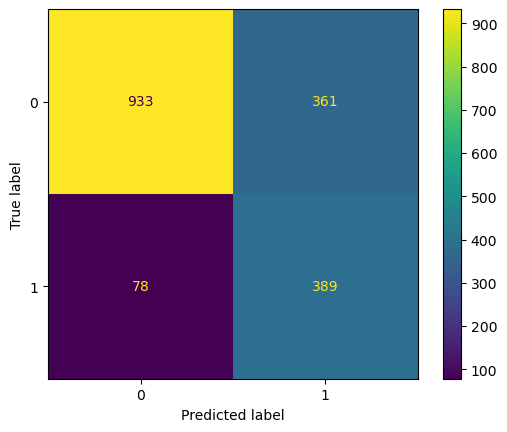

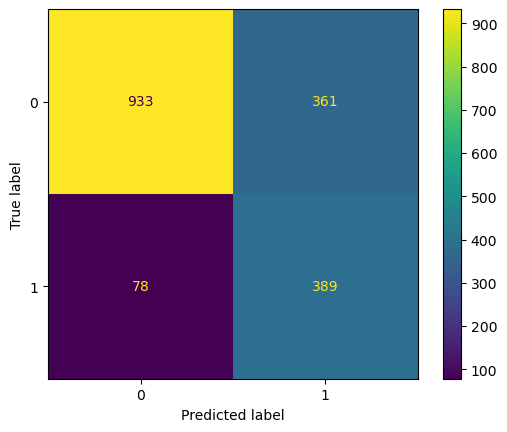

C:\Users\lynst\anaconda3\lib\site-packages\joblib\_memmapping_reducer.py:607: UserWarning: Failed to delete temporary folder: C:\Users\lynst\AppData\Local\Temp\joblib_memmapping_folder_10772_67dd3a186ef143d39e547ec65646e015_b226de550aba44e7b7c51f4151c5453f
  warnings.warn("Failed to delete temporary folder: {}"


In [44]:
y_pred = clf_xgb.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

'''
plot_confusion_matrix(clf_xgb,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Did not leave", "Left"])'''


We see that the optimized XGBoost model is a lot better at identifying people that left the company. Of the 467 people that left the company, 390 (84%) were correctly identified. Before optimization we only correctly identified 239 (51%), however this improvement was at the expense of not being able to correctly classify as many people that did not leave.

The last thing we're going to do is draw the first XGBoost tree and discuss how to interpret it.

In [ ]:
## If we want to get information, like gain and cover etc, at each node in the first tree
## we will just build the first tree, otherwise we'll get the average over all of the trees.

clf_xgb = xgb.XGBClassifier(seed=42,
                           objective='binary:logistic',
                           gamma=0.25,
                           learning_rate=0.1,
                           max_depth=4,
                           reg_lambda=10,
                           scale_pos_weight=3,
                           subsample=0.9,
                           colsample_bytree=0.5,
                           n_estimators=1)

clf_xgb.fit(X_train, y_train)

In [ ]:
bst = clf_xgb.get_booster()

In [ ]:
for importance_type in ('weight','gain','cover','total_gain','total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

In [ ]:
node_params = {'shape': 'box',      # make the nodes fancy
               'style': 'filled','rounded',
               'fillcolor': '#78cbe'}

In [ ]:
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}

In [ ]:
xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)

Now let's discuss how to interpret the XGBoost tree. In each node we have:

1. The variable (column name) and the threshold for splitting the observations. For example, in the trees root we use Contract Month_to_month to split the observations. All observations with Contract 'Month_to_month < 1 go to the left and all others go to the right (i.e. values >= 1).